# Introducción a Validación de Modelos

Los algoritmos de aprendizaje automático se entrenan mediante la optimizaicón de una función sobre los datos de entrenamiento. Por ende, mal se puede validar la hipótesis aprendida sobre los mismo datos que su usaron para formularla. Si lo hiciéramos, lejos de obtener una métrica adecuada de lo bien que generalizará nuestro modelo, sólo tendríamos una evaluación de qué tan bien se ajusta a los datos de entrenamiento. Cuando ese ajuste es muy fuerte y la generalización es muy mala, se dice que incurrimos en un ajuste exesivo (overfitting).

Exísten una serie de métodos que nos permiten estimar qué tan bien generalizará un determinado modelo. En primer término, la simple división entre entrenamiento y validación puede dar la primera aproximación. Generalizando esta idea, se llega a la técnica de validación cruzada (cross-validation) que es la división en k subconjuntos disyuntos de entrenamiento y validación. Llevado al extremo, tenemos los métodos de dejar-p-afuera (leave p out), que cuando p=1, implica el entrenamiento de n modelos para precedir en cada uno de los casos, habiendo entrenado en todos los demás. 


## Separación simple en entrenamiento y validación

En el tutorial anterior, vimos un ejemplo de tomar un p% de casos al azar para validación, entrenando con el restante (1-p)%. Ese fue un caso de simple separación aleatoria entre entrenamiento y validación. 

Scikit Learn es una librería que no sólo tiene una amplia variedad de algoritmos de aprendizaje automático, sino que provee una gran cantidad de funciones auxiliares para simplificar el tratamiento de los datos, entre ellas, las de validación. 


In [1]:
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
sns.set()

/Users/adambrosio/opt/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [14]:
#setup para el notebook
%matplotlib inline
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (10, 8)

In [3]:
try:
    data = pd.read_csv("../data/titanic_proc.csv", index_col="PassengerId")
except:
    data = pd.read_csv("https://raw.githubusercontent.com/Argentan/DMA_LAB2/master/data/titanic_proc.csv", index_col="PassengerId")
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,NumFam,C,Q,S,Age_nul
PassengerId,,,,,,,,,,,,,,
1,0,3,0,22.00,1,0,0,7.25,0,1,0,0,1,0
2,1,1,1,38.00,1,0,1,71.28,1,1,1,0,0,0
3,1,3,1,26.00,0,0,2,7.92,0,0,0,0,1,0
4,1,1,1,35.00,1,0,3,53.10,2,1,0,0,1,0
5,0,3,0,35.00,0,0,4,8.05,0,0,0,0,1,0


Vemos la ayuda de la función `train_test_split`

In [ ]:
model_selection.train_test_split?

In [4]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(data.drop("Survived", axis=1), 
                                                                    data.Survived, test_size=0.1, random_state=0)
print(f"X_train: {X_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_valid: {y_valid.shape}")

X_train: (801, 13)
X_valid: (90, 13)
y_train: (801,)
y_valid: (90,)


In [7]:
y_train.mean()

0.3782771535580524

In [6]:
y_valid.mean()

0.43333333333333335

In [ ]:
print(X_train.head())
y_train.head()

## Ajuste de Hiperparámetros

Vamos a comenzar ajustando los valores posibles de un parámetro `max_depth` en un modelo de `RandomForestClassifier`

In [8]:
depths = list(range(2, 40, 2)) + [None]
depths

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, None]

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score

Armamos un DF para guardar los resultados

In [10]:
res = pd.DataFrame([], index=[str(d) for d in depths], columns=["train", "valid"])
res

,train,valid
2,NaN,NaN
4,NaN,NaN
6,NaN,NaN
8,NaN,NaN
10,NaN,NaN
...,...,...
32,NaN,NaN
34,NaN,NaN
36,NaN,NaN
38,NaN,NaN


Luego entrenamos el modelo con los distintos valores del parámetro y vemos como mejora la Entropía cruzada (log loss)

In [11]:
for depth,i in zip(depths,range(len(depths))):
    
    learner = RandomForestClassifier(n_estimators=100, max_depth=depth)
    
    learner.fit(X_train, y_train)

    res.loc[str(depth), "train"] = log_loss(y_train, learner.predict_proba(X_train))
    res.loc[str(depth), "valid"] = log_loss(y_valid, learner.predict_proba(X_valid))
    
    print('{:.2%}'.format((i+1)/len(depths)),end='\r')

In [ ]:
res

Graficamos el resultado

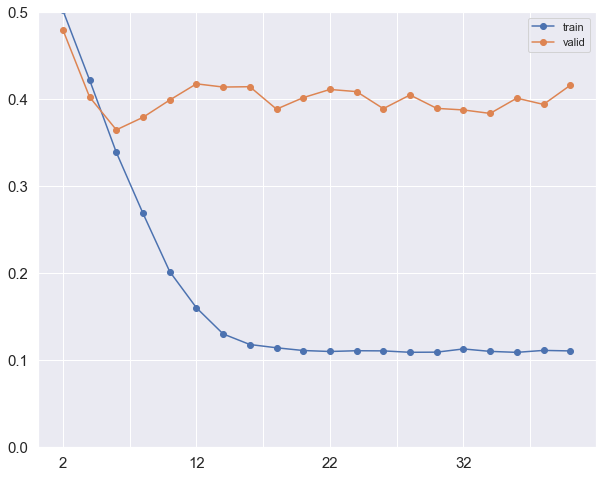

In [15]:
ax = res.plot.line(grid=True, fontsize=15, ylim=(0, 0.5), linestyle='-', style='o')

Ahora, calculamos el área bajo la ROC Curve sobre los mismos modelos


In [16]:
res = pd.DataFrame([], index=[str(d) for d in depths], columns=["train", "valid"])
for depth,i in zip(depths,range(len(depths))):
    learner = RandomForestClassifier(n_estimators=100, max_depth=depth)
    learner.fit(X_train, y_train)
    res.loc[str(depth), "train"] = roc_auc_score(y_train, learner.predict_proba(X_train)[:, -1])
    res.loc[str(depth), "valid"] = roc_auc_score(y_valid, learner.predict_proba(X_valid)[:, -1])
    print('{:.2%}'.format((i+1)/len(depths)),end='\r')

In [17]:
res

,train,valid
2,0.86,0.93
4,0.89,0.94
6,0.93,0.93
8,0.97,0.93
10,0.99,0.90
...,...,...
32,1.00,0.89
34,1.00,0.89
36,1.00,0.88
38,1.00,0.89


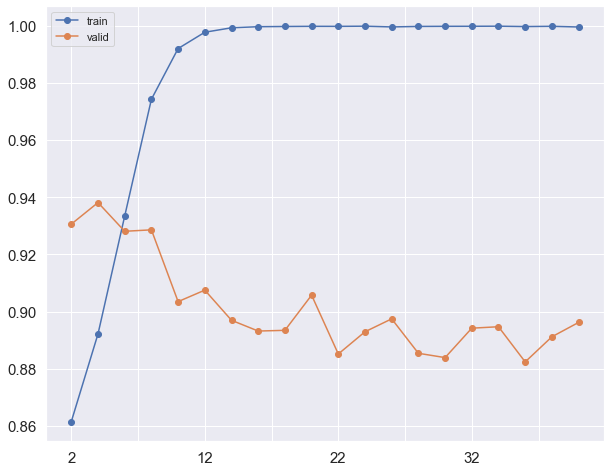

In [18]:
ax = res.plot.line(grid=True, fontsize=15, linestyle='-', style='o')

Veamos como es la supervivencia por deciles

In [ ]:
# En Train
pd.crosstab(pd.cut(learner.predict_proba(X_train)[:, -1], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,1]), y_train)

In [ ]:
# En Test
pd.crosstab(pd.cut(learner.predict_proba(X_valid)[:, -1], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,1]), y_valid)

## Validación Cruzada en K conjuntos (K-fold cross validation)

Este método consiste en dividir el set de entrenamiento en K subconjuntos disyuntos, para luego iterativamente entrenar el algoritmo en k-1 partes y evaluar en la restante. 

Scikit Learn también tiene funciones para hacer estas divisiones


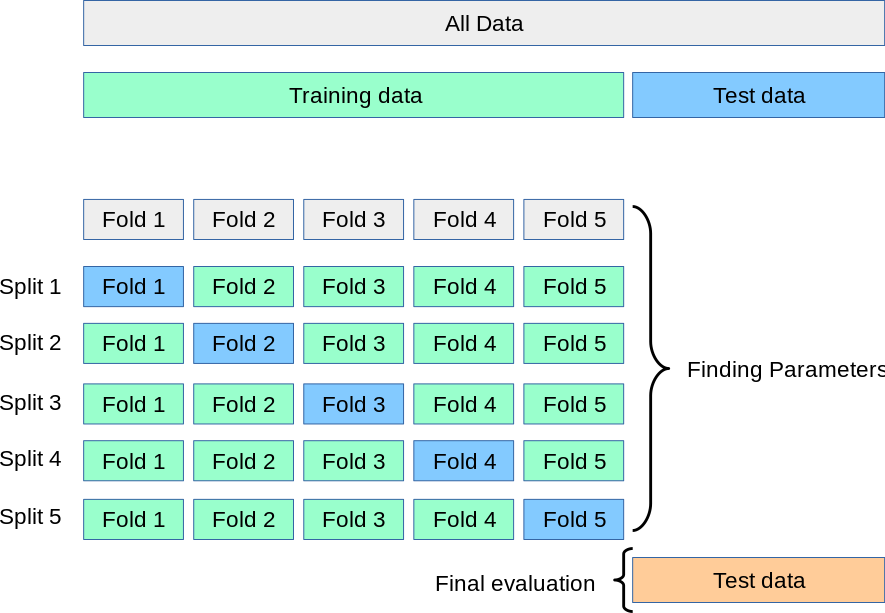

In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
X,y=data.drop("Survived", axis=1),data.Survived

In [21]:
learner = RandomForestClassifier(n_estimators=100, max_depth=6)

scores = cross_val_score(learner, X, y, cv=5)

In [22]:
scores

array([0.79329609, 0.8258427 , 0.83146067, 0.80337079, 0.84831461])

In [23]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.82 accuracy with a standard deviation of 0.02


## Combinación de métodos  y determinación de cantidad de iteraciones

Ambos métodos se pueden combinar para hacer una estimación mas completa, con el beneficio agregado que, para algunso tipos de algoritmos, se puede facilitar la estimación de la cantidad de iteraciones (ej. boosting o redes neuronales)


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data.drop("Survived", axis=1), 
                                                                    data.Survived, test_size=0.2, random_state=0)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
depths = list(range(2, 42,10))
folds=5
res = pd.DataFrame([], index=[str(d) for d in depths], columns=["fold_" + str(i) for i in range(folds)] + ["valid","test"])
for depth,j in zip(depths,range(len(depths))):
    learner = RandomForestClassifier(n_estimators=100, max_depth=4)
    scores = cross_val_score(learner, X_train, y_train, cv=folds)
    for i in range(folds):
        columna='fold_{}'.format(i)
        res.loc[str(depth)][columna]=scores[i]
    res.loc[str(depth)]['valid']=scores.mean()
    learner.fit(X_train,y_train)
    res.loc[str(depth)]['test']=learner.score(X_test,y_test)
    print('{:.2%}'.format((j+1)/len(depths)),end='\r')
res

# Ejercitación



1.   Tomar los Datos Procesados de Titanic de la clase pasada
2.   Hacer una separación 80/20 en Train y Test
3.   Para la parte de Train, armar un esquema de CV con 5 Folds
4.   Entrenar un modelo de Random Forest, optimizando un parámetro al elección
5.   Evaluar cual es el máximo Area bajo la Curva ROC que se obtiene